# HM04 - Applied ML

### Plan :
0 - Cleaning and Analysing Data<br/>
1 - Supervised Learning : Random Forest<br/>
2 - Unsupervised Learning : Clustering

# 0 - Cleaning and Analysing Data

In this first part, we analyse and clean the data in order to understand them and work on a clean Dataset.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cross_validation import train_test_split, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0 - a - Loading Data

The data contains dyads of soccer players and referees. 

In [3]:
path = 'CrowdstormingDataJuly1st.csv'
raw_data  = pd.read_csv(path)
print(raw_data .shape)
raw_data .head(5)

(146028, 28)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


We've got 146 028 dyads, described by 28 features.<br/>
Each row should be described by an unique pair (player, referee). Is it the case?

In [4]:
raw_data[['playerShort', 'refNum']].duplicated().value_counts()

False    146028
dtype: int64

Actually, each pair (player, referee) is unique.

### 0 - b - Skin rating processing

In our study, we are interested on the skin tone of the players.<br/>
This skin tone is determined by 2 raters, using their photo.<br/>
As some photos are missing, we should first delete the affected rows.

In [26]:
df = raw_data.dropna(subset=['photoID'])
df.shape[0]

124621

The skin is rated  with a 5-point scale ranging from “very light skin” to “very dark skin” :

In [27]:
np.sort(df['rater1'].unique()), np.sort(df['rater2'].unique())

(array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ]))

Are these ratings reliable?

In [28]:
np.abs(df['rater2'] - df['rater1']).describe()

count    124621.000000
mean          0.058319
std           0.106505
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.500000
dtype: float64

In [29]:
df.loc[np.abs(df['rater2'] - df['rater1']) == 0.5].shape[0]

164

In some cases, the raters disagree. Let's remove these meaningless ratings :

In [31]:
index_unreliable = df.loc[np.abs(df['rater2'] - df['rater1']) == 0.5].index
df = df.drop(index_unreliable)
df.shape[0]

124457

For each row, we compute the mean of the ratings as an estimator of the skin tone of the player :

In [32]:
df['skin'] = df[['rater1', 'rater2']].mean(axis=1)

In this dyads' dataframe, how are the skin tones represented?

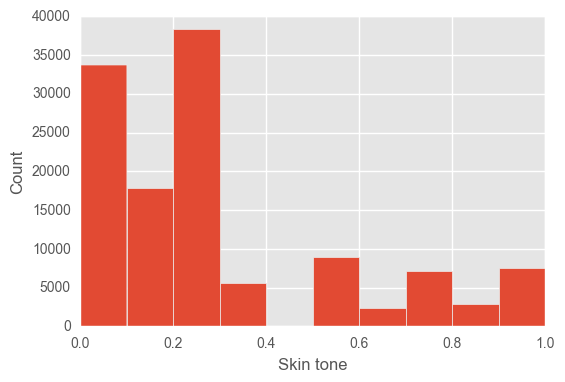

In [33]:
plt.hist(df.skin)
plt.xlabel("Skin tone") 
plt.ylabel("Count")

- It would seem that "light" skin are more represented than "dark" skins. (but we should have a look at the "player" dataframe to get an accurate idea of it!)
- "Light" and "Dark" skins are well separated; we could split it into 2 classes.

Let's discretise the skin tone by width :
- One time using the initial scale in 5 values
- Another time using a binary scale (2 values)

In [34]:
# round x to their nearest n_val values
def discretize_by_width (x, nb_values): # x appartient à 01
    return ((nb_values-1)*x).round()/(nb_values-1)

df['skin_discretized_5'] = discretize_by_width(df.skin, 5)
df['skin_discretized_2'] = discretize_by_width(df.skin, 2)

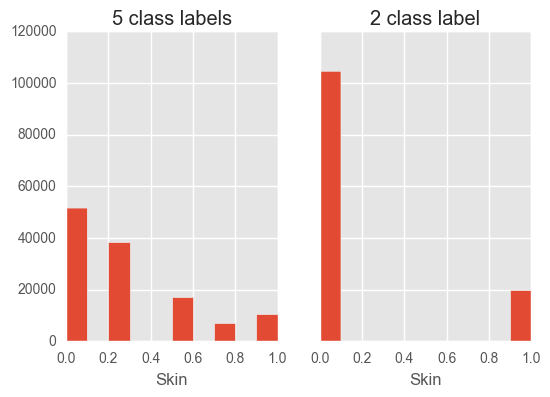

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(df.skin_discretized_5)
ax1.set_title('5 class labels')
ax1.set_xlabel("Skin") 
ax2.hist(df.skin_discretized_2)
ax2.set_title('2 class label')
ax2.set_xlabel("Skin") 

### 0 - c - Null features processing

Is there null values in our dataset? What are the affected features?

In [36]:
df.columns[df.isnull().any()]

Index(['height', 'weight', 'position', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

We choose to delete the affected rows :

In [37]:
initial_shape = df.shape[0]
df.dropna(inplace=True)
print(initial_shape - df.shape[0], " rows deleted")

9164  rows deleted


### 0 - d - Data Analysis
The dataset can be seen as the join of 4 datasets :
- The players
- The referees
- The referees' countries
- The player/referee dyads

Let's learn a bit more about our data and analyse these 4 datasets !

- **Players**

In [82]:
df['playerShort'].value_counts().describe()

count    1417.000000
mean       81.364150
std        34.635716
min         1.000000
25%        56.000000
50%        77.000000
75%       103.000000
max       202.000000
Name: playerShort, dtype: float64

We've got 1417 players, meeting on average 381 referees (ranging from 1 to 202)<br/>
Let's build the players' dataframe, aggregating some other values linked to the dyads (as games and cards). 

In [38]:
def identity(x):
    return list(x)[0]    # type(x) = pandas.core.series.Series / players.feature = pandas.core.series

players = df.groupby(df['playerShort'])
players = players.agg({'player': identity, 'club':identity, 'leagueCountry':identity, 'birthday':identity, 
             'height':identity, 'weight':identity, 'position':identity, 
             'games':sum, 'victories':sum, 'ties':sum, 'defeats':sum, 'goals':sum, 
             'yellowCards':sum, 'yellowReds':sum, 'redCards':sum, 'skin':identity})

Let's have a look at the average of the numerical features :

In [39]:
players.mean()

skin             0.282816
redCards         1.042343
weight          76.278052
yellowCards     32.936486
ties            58.687368
goals           29.310515
yellowReds       1.001411
games          246.880734
height         182.170783
defeats         76.621736
victories      111.571630
dtype: float64

- The averaged skin tone is "light"
- There are more yellowCards than the two others

In [40]:
players.leagueCountry.value_counts()

Germany    461
Spain      404
England    323
France     229
Name: leagueCountry, dtype: int64

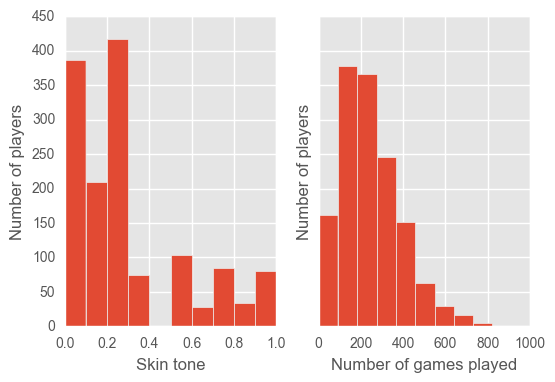

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(players['skin'])
ax1.set_xlabel("Skin tone") 
ax1.set_ylabel("Number of players")

ax2.hist(players['games'])
ax2.set_xlabel("Number of games played") 
ax2.set_ylabel("Number of players")

- **Player/Referee dyads**

Now, let's have a look at the specific dyads' features :

In [48]:
df[['games','victories', 'ties', 'defeats', 'yellowCards', 'yellowReds', 'redCards']].mean()

games          3.034269
victories      1.371263
ties           0.721293
defeats        0.941714
yellowCards    0.404803
yellowReds     0.012308
redCards       0.012811
dtype: float64

- **Referees**

In [49]:
df['refNum'].value_counts().describe()

count    2893.000000
mean       39.852402
std        87.977242
min         1.000000
25%         2.000000
50%         8.000000
75%        31.000000
max       770.000000
Name: refNum, dtype: float64

We've got 2893 referees, meeting on average 40 players (ranging from 1 to 770)<br/>
Let's build the referees' dataframe, aggregating some other values linked to the dyads (as games and cards). 

In [42]:
referees = df.groupby(df['refNum'])
referees = referees.agg({'refCountry': identity, 'games':sum, 'goals':sum, 'yellowCards':sum, 'yellowReds':sum, 'redCards':sum})

In [43]:
referees.describe()

,goals,yellowReds,games,redCards,refCountry,yellowCards
count,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000
mean,14.356377,0.490494,120.922917,0.510543,39.168337,16.132389
std,46.491978,1.927363,418.575011,1.927537,33.301968,58.181324
min,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,3.000000,0.000000,8.000000,0.000000
50%,2.000000,0.000000,11.000000,0.000000,32.000000,1.000000
75%,8.000000,0.000000,52.000000,0.000000,57.000000,6.000000
max,519.000000,28.000000,5186.000000,22.000000,161.000000,698.000000


We notice that some referees are a lot more present than average. 

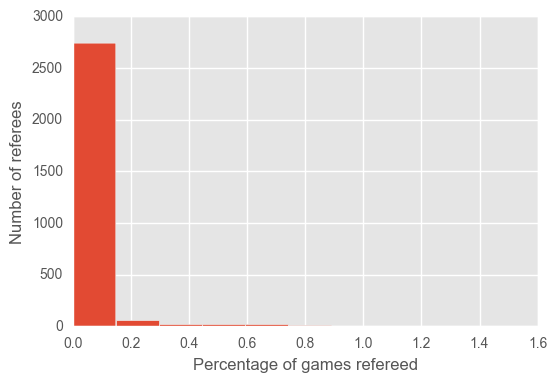

In [46]:
nb_games = sum(referees['games']) # number of games
plt.hist((referees['games']/nb_games)*100)
plt.xlabel("Percentage of games refereed") 
plt.ylabel("Number of referees")

- **Referees' countries**

We can use the referees' dataset to how many referees come from each country :

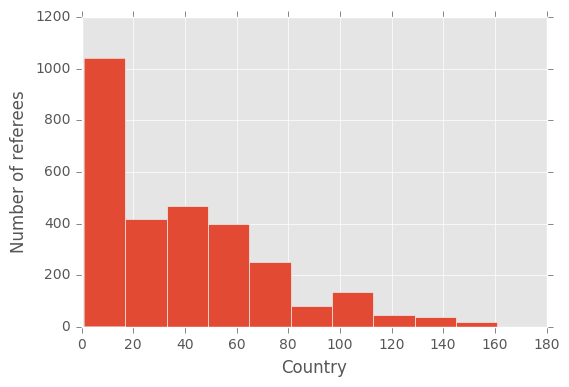

In [55]:
plt.hist(referees['refCountry'])
plt.xlabel("Country") 
plt.ylabel("Number of referees")

A lot of country counts a poor number of referees.<br/>
Let's build the countries' dataset :

In [57]:
refCountry = df[['refCountry','meanIAT','nIAT', 'seIAT', 'meanExp', 'nExp']]
refCountry = refCountry.drop_duplicates()
refCountry.shape

(152, 6)

In [58]:
refCountry.describe()

,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp
count,152.000000,152.000000,1.520000e+02,1.520000e+02,152.000000,1.520000e+02
mean,78.296053,0.305099,1.504561e+04,1.312417e-02,0.291296,1.548661e+04
std,45.475245,0.106170,1.602920e+05,3.252193e-02,0.640170,1.646550e+05
min,1.000000,-0.047254,2.000000e+00,2.235373e-07,-1.375000,2.000000e+00
25%,39.750000,0.262227,3.975000e+01,5.997501e-04,0.022440,4.075000e+01
50%,77.500000,0.340406,1.995000e+02,2.215379e-03,0.395070,2.070000e+02
75%,116.250000,0.371913,6.700000e+02,1.050398e-02,0.638593,7.065000e+02
max,161.000000,0.573793,1.975803e+06,2.862871e-01,1.800000,2.029548e+06


### 0 - e - Features' analysis

- **Useless features**

Some features are useless : *photoID*, *rater1*, *rater2* were only used to build the *skin* feature: we don't need them anymore. 

In [47]:
df = df.drop('photoID',axis=1)
df = df.drop('rater1',axis=1)
df = df.drop('rater2',axis=1)

- **Redondant features**

As the dataset is the join of several datasets, some features are redondant :
    - The features specific to one particular player
    - The features specific to one particular country
    - The features specific to one particular referee (ie, his country)

- **Correlated features**

Some features are intuitively correlated :
    - The number of games is correlated with the sum of victories and defeats
    - The number of yellowreds may be correlated with the number of yellowCards

- **Feature transformation** -> to numerical

Our algorithms will use numerical features. However, some of our features are strings.<br/>
But these features are categorical (and not ordinal), so it doesn't make any sense to convert it into numerical values.<br/>
Yet, we can still conserve the year of birth :

In [48]:
df['year'] = df['birthday'].apply(lambda x: int(x.split('.')[2]))

### 0 - e - Building labels and features datasets

For the supervised learning part, we choose to keep the original dyad's dataset instead of a player's dataset (even if it implies to deal with redondant data). Indeed, by aggregating features in a player's dataset, we loose a lot of information.

- ** Labels **

For the supervised learning, we choose to keep 5 labels to represent the skin tone :

In [53]:
y = np.asarray(df['skin_discretized_5'], dtype="|S6")

- ** Features **

In [132]:
X = df.copy()
# Drop the labels and non-numerical features (refNum and refCountry are part of them!)
X = X.drop(['skin', 'skin_discretized_5', 'skin_discretized_2',
           'playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'position', 'Alpha_3', 'refNum', 'refCountry'], axis=1)

- ** Features standardization **

In [133]:
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    x = x / std_x
    return x

In [134]:
X = standardize(X)

- **Features correlation with y**

In [135]:
y_X = pd.concat([df['skin_discretized_5'],X], axis=1)
corr = y_X.corr()
corr = corr['skin_discretized_5'] # correlation between y and D features
corr = corr.drop('skin_discretized_5')

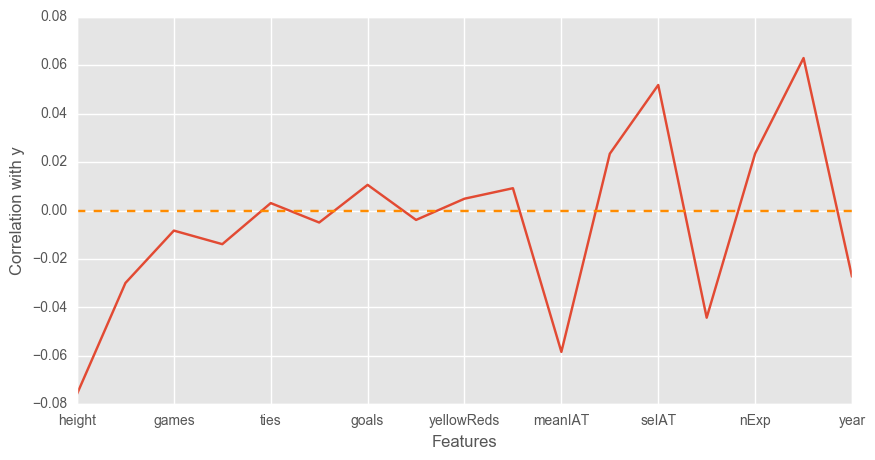

In [136]:
g = corr.plot(figsize =(10,5), x = 'index')
g.axhline(0,color='#FF8C00', linestyle='--')
g.set_xlabel("Features")
g.set_ylabel("Correlation with y") 

In [137]:
abs(corr).sort_values(ascending=False).head(6)

height     0.075737
seExp      0.062987
meanIAT    0.058348
seIAT      0.051858
meanExp    0.044224
weight     0.029897
Name: skin_discretized_5, dtype: float64

If the correlation coefficient :<br/>
= 0     => No correlation<br/>
= -1/1  => Correlation<br/><br/>
*Height*, *seExp*, *meanIAT*, *seIAT*, *meanExp* and *weight* are the most correlated features with y. <br/>

# 1 - Supervised Learning : Random Forests

In this part, we will predict the skin tone of a player (given dyad's information) using a supervised method : random forests.

* **Train/test split**

In [138]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

- **1st random forest classifier**

Now, we build our first random forest classifier, with default parameters (n_estimators=10 arbres, max_depth = None).<br/>
Then, we train the model on the training set.

In [139]:
# instantiate the model (using the default parameters)
rfc = RandomForestClassifier(n_jobs=-1)
# fit the model with data
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's define a function to print the model's accuracy :

In [112]:
def print_score(classifier, X_train, y_train, X_test, y_test):
    print('Train set score :', classifier.score(X_train, y_train))
    print('Test set score :', classifier.score(X_test, y_test))

In [140]:
print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.988579689194
Test set score : 0.835010191249


We observe that the model is overfitting (the training set score is really high while the test set one is a bit less important)

- <b>Influence of parameters</b>

Random Forests include 2 fondamental parameters :
    - max_depth (reduces bias)
    - n_estimators (reduces variance, and so, overfitting)

We saw that our model was overfitting. <br/>
We can decrease this overfitting by increasing the number of maximum features

In [141]:
rfc = RandomForestClassifier(max_features=None, n_jobs=-1)
rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.990589085652
Test set score : 0.960210763693


We can also decrease it by increasing the number of trees :

In [142]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.992916516082
Test set score : 0.87711956286


But increasing this parameter increases also the computation time.. (more than the test accuracy!)

- <b>Perform cross-validation to mitigate the overfitting of your model </b>

We can use cross-validation to find the optimal value of parameters.<br/>
Let's find the optimal value for the *max_features* parameter :

In [143]:
max_features_range = list(range(5, 18))
max_features_scores = []
for mf in max_features_range:
    rfc = RandomForestClassifier(max_features=mf, n_jobs=-1)
    scores = cross_val_score(rfc, X, y, cv=3, scoring='accuracy')
    max_features_scores.append(scores.mean())

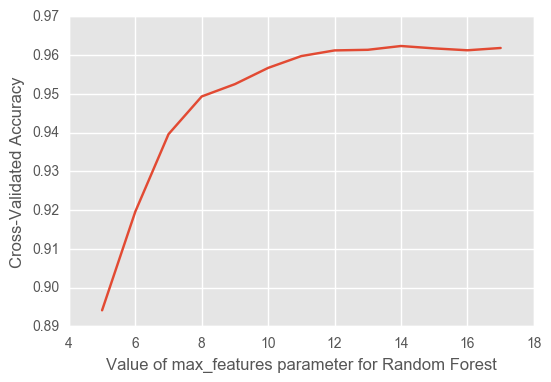

In [144]:
# plot the value of for max_features (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(max_features_range, max_features_scores)
plt.xlabel('Value of max_features parameter for Random Forest')
plt.ylabel('Cross-Validated Accuracy')

In [145]:
range_score = pd.DataFrame(np.c_[max_features_range, max_features_scores], columns = ['max_features', 'score'])
range_score.loc[range_score.score == max(range_score.score)].max_features

9    14.0
Name: max_features, dtype: float64

The optimal paramet for max_feature paramater seems to be 14.
Let's build this new classifier with this value.

In [146]:
rfc = RandomForestClassifier(max_features=14, n_jobs=-1)
model = rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.991268521865
Test set score : 0.960492649291


The overfitting is reduced !<br/>
We can reduce it a bit more by increasing the number of trees :

In [148]:
rfc = RandomForestClassifier(max_features=14, n_estimators=100, n_jobs=-1)
model = rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.992916516082
Test set score : 0.963593390867


- <b>The feature\_importances_ attribute </b>

Let's define a function to plot the features importances :

In [126]:
def plot_features_importances(ft_imp):
    plt.figure()
    ft_imp.plot(kind='bar')
    
    #plt.title('Feature importance for the trained random forest model')
    plt.xlabel('Feature name', fontweight='bold')
    plt.ylabel('Features importance [%]', fontweight='bold')
    plt.show()

We extract and plot the features importances

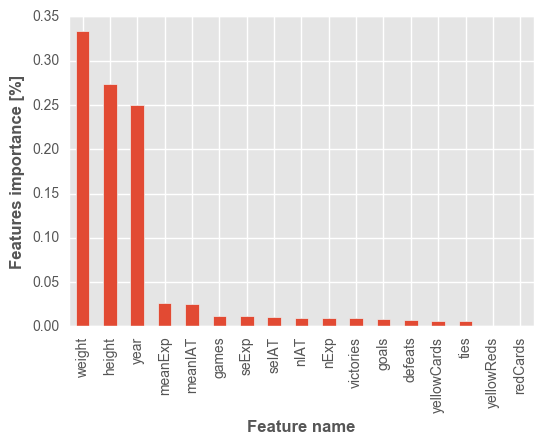

In [149]:
# Extract features importances from model
features_importances = model.feature_importances_

# Create series from features importances and features names
ft_imp = pd.Series(features_importances, index=X.columns.values).sort_values(ascending=False)

# Plot features
plot_features_importances(ft_imp)

    - yellowReds and redCards are not used
    - Three features stands out : 'height', 'weight' and 'year'. 
    - Remember, we already computed a measure of the features importance (its correlation with y). The order is different, but we find almost the same "most" important features.

- <b>With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature\_importances_ attribute?</b>

Let's try a model using only the 5 most important features : weight, height, year, meanExp and meanIAT

In [150]:
# number of features choosen
n_features = 5

# extract reduced features set and drop NaN values
X_reduced = df[ft_imp.head(n_features).index].copy()
X_reduced.head(2)

,weight,height,year,meanExp,meanIAT
0,72.0,177.0,1983,0.396000,0.326391
1,82.0,179.0,1982,-0.204082,0.203375


We can now train our random forest classifier on the reduced data set

In [151]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.4, random_state=4)

rfc_r = RandomForestClassifier(n_jobs=-1)
model_r = rfc_r.fit(X_train_r, y_train_r)

print_score(rfc_r, X_train_r, y_train_r, X_test_r, y_test_r)

Train set score : 0.975424647633
Test set score : 0.949260592393


The test set score is pretty good, with only 5 features !<br/>
Let's look again at the features importances :

In [152]:
# Extract features importances from model
features_importances_reduced = model_r.feature_importances_

# Create series from features importances and features names
ft_imp_r = pd.Series(features_importances_reduced, index=X_reduced.columns.values).sort_values(ascending=False)

# Compare features importance
pd.concat([ft_imp*100, ft_imp_r*100], axis=1, join='inner')

,0,1
weight,33.409475,36.114197
height,27.429820,28.677751
year,24.970794,23.358919
meanExp,2.638425,6.030184
meanIAT,2.540252,5.818949


The order of the features importance is the same but the importance of meanExp and meanIAT has tripled.

- <b>BONUS: plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?</b>

We know that we can influence bias by adjusting the trees' depth.

#### High Bias (low Train Score) : max_depth = 3

In [153]:
rfc = RandomForestClassifier(max_depth=3, max_features=14, n_estimators=10, n_jobs=-1)

training_sizes=np.array([0.1, 0.325, 0.55, 0.775, 1.]) # set training batch sizes
n_folds = 20 # set n-folds cross validation

# compute learning curve
train_sizes, train_scores, valid_scores = learning_curve(rfc, X, y, train_sizes=training_sizes, cv=n_folds, n_jobs=-1)

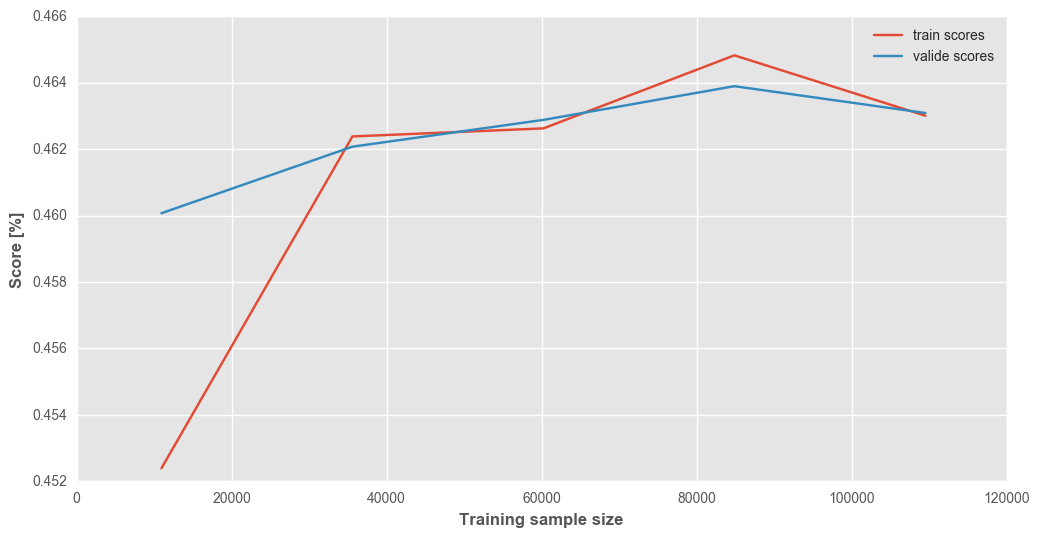

In [154]:
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_scores.mean(axis=1))
plt.plot(train_sizes, valid_scores.mean(axis=1))
plt.legend(['train scores','valide scores'])
plt.xlabel('Training sample size', fontweight='bold')
plt.ylabel('Score [%]', fontweight='bold')
plt.show()

When we faces an high bias, more data doesn't help (the test and training accuracy remains under 50%)

#### Small Bias (high Train Score : max_depth = 150)

In [157]:
rfc = RandomForestClassifier(max_depth=150, max_features=14, n_estimators=10, n_jobs=-1)

training_sizes=np.array([0.1, 0.325, 0.55, 0.775, 1.]) # set training batch sizes
n_folds = 20 # set n-folds cross validation

# compute learning curve
train_sizes, train_scores, valid_scores = learning_curve(rfc, X, y, train_sizes=training_sizes, cv=n_folds, n_jobs=-1)

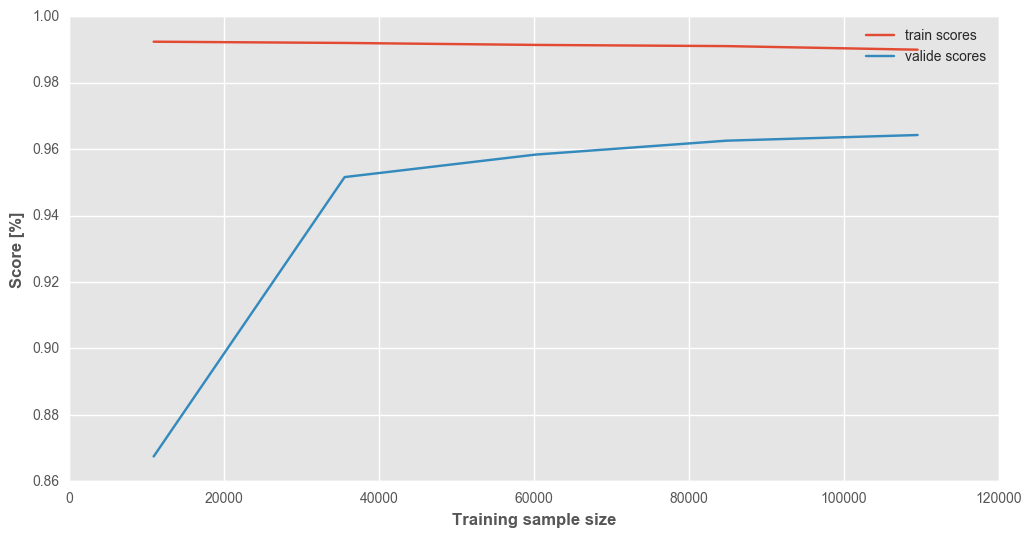

In [158]:
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_scores.mean(axis=1))
plt.plot(train_sizes, valid_scores.mean(axis=1))
plt.legend(['train scores','valide scores'])
plt.xlabel('Training sample size', fontweight='bold')
plt.ylabel('Score [%]', fontweight='bold')
plt.show()

When we have a small bias, more data can help to reduce variance (as it is the case here).

# 2. Clustering using an unsupervised learning technique

In this part, we will use an unsupervised technique (K-Means) to cluster the soccer players in 2 disjoint clusters.<br/>
We will see if we can find a configuration of features where players with dark and light skin colors belong to different
clusters.

- <b>Aggregate the referee information grouping by soccer player</b>

In [264]:
def mean(x):
    return np.mean(x)

players_df_ns = df.groupby(df['playerShort'])
# take only numerical features
players_df_ns = players_df_ns.agg({'height':identity, 'weight':identity, 'skin':identity, 'year':identity,
                              'games':sum, 'victories':sum, 'ties':sum, 'defeats':sum, 'goals':sum, 
                              'yellowCards':sum, 'yellowReds':sum, 'redCards':sum,
                              'meanIAT': mean, 'nIAT': mean, 'seIAT': mean, 
                              'meanExp': mean, 'nExp': mean, 'seExp': mean
                             })

The number of cards, goals, victories... is proportionnal to the number of games played. So, we divide these features by the number of games :

In [265]:
for feature in ['victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']:
    players_df_ns[feature] = players_df_ns[feature] / players_df_ns.games

Now, we standardize the dataset :

In [266]:
players_df = standardize(players_df_ns)
players_df.head(2)

,skin,meanIAT,seExp,redCards,year,weight,yellowCards,ties,defeats,goals,yellowReds,nExp,games,nIAT,seIAT,height,meanExp,victories
playerShort,,,,,,,,,,,,,,,,,,
aaron-hughes,-0.549349,-0.188539,0.291169,-0.728126,-1.519347,-0.743505,-1.378934,0.751504,0.251795,-0.816500,-0.690829,0.149509,2.881194,0.141324,0.059161,-0.025119,0.309252,-0.582505
aaron-hunt,-0.549349,-0.004801,-0.416213,-0.231371,0.084911,-0.461770,-0.137526,-0.445040,0.426934,0.680839,-0.690829,0.374394,0.630699,0.379086,-0.395373,0.121964,-0.179684,-0.147926


- <b>Use an unsupervised learning technique to cluster the players in 2 disjoint clusters.</b>

Let's try a K-Means clustering on the Dataset (K = 2)

In [199]:
kmeans_model = KMeans(n_clusters=2)
clust_model = kmeans_model.fit(players_df)
score = silhouette_score(players_df, clust_model.predict(players_df))
score

0.11245151197278028

Not a really convincing score..

- <b>Feature selection : Ablation</b>

At each iteration, we remove the feature without which we obtain the better score.<br/>
We continue while the silhouette score is improving.

In [165]:
def find_feature_to_delete(X):
    
    nb_features = X.shape[1]
    scores = np.zeros(nb_features)
    
    for nb_f in list(range(nb_features)):
        
        x_del = X.drop(X.columns[nb_f], axis=1)
        kmeans_model = KMeans(n_clusters=2)
        clust_model = kmeans_model.fit(x_del)
        
        scores[nb_f]=silhouette_score(x_del, clust_model.predict(x_del))
    
    return X.columns[np.argmax(scores)], np.max(scores)

In [200]:
old_score = 0  
# init : score = 0.10767790851
players_df_reduced = players_df.copy()

print("Initial Score : ", score)

while (players_df_reduced.shape[1] > 1):
    old_score = score
    feature, score = find_feature_to_delete(players_df_reduced)
    if (score > old_score):
        print("Deleted feature = ", feature, " \t \t Score = ", score)
        players_df_reduced = players_df_reduced.drop(feature, axis=1)
    else :
        break

Initial Score :  0.112451511973
Deleted feature =  meanIAT  	 	 Score =  0.130856109636
Deleted feature =  yellowReds  	 	 Score =  0.144559310327
Deleted feature =  redCards  	 	 Score =  0.154998168103
Deleted feature =  meanExp  	 	 Score =  0.167929359441
Deleted feature =  yellowCards  	 	 Score =  0.183782194164
Deleted feature =  weight  	 	 Score =  0.200240205892
Deleted feature =  year  	 	 Score =  0.217493703864
Deleted feature =  victories  	 	 Score =  0.401146276045
Deleted feature =  height  	 	 Score =  0.433146733052
Deleted feature =  goals  	 	 Score =  0.497851953162
Deleted feature =  seIAT  	 	 Score =  0.657329979654
Deleted feature =  ties  	 	 Score =  0.747065900722
Deleted feature =  defeats  	 	 Score =  0.814675635724
Deleted feature =  seExp  	 	 Score =  0.841966309369


In [201]:
players_df_reduced.shape[1], players_df_reduced.columns

(4, Index(['skin', 'nExp', 'games', 'nIAT'], dtype='object'))

With Ablation's selection method, we find the best clustering by using ['skin', 'nExp', 'games', 'nIAT'] as parameters.

In [274]:
kmeans_model = KMeans(n_clusters=2)
clust_model = kmeans_model.fit(players_df_reduced)
y_pred = clust_model.predict(players_df_reduced)
score = silhouette_score(players_df_reduced, y_pred)
print(score)

0.754301154792


That's much better !<br/>
Let's have a look at these clusters :

In [275]:
skin_cluster = np.c_[np.asarray(players_df_ns['skin']), y_pred]
skin_cluster = pd.DataFrame(skin_cluster, columns=['skin','cluster'])

In [278]:
skin_cluster_grouped = skin_cluster.groupby(skin_cluster['cluster']).mean()
skin_cluster_grouped

,skin
cluster,
0.0,0.279996
1.0,0.470238


It seems that cluster 1 contains an higher proportion of "dark" skin people.<br/>
But...

In [276]:
skin_cluster['cluster'].value_counts()

0.0    1396
1.0      21
Name: cluster, dtype: int64

Given the proportion of players in each cluster, this classification doesn't make any sense in term of skin tone.<br/>
This can be explain by the fact that :
    - Features are not equally represented (more 'light' skin players, more referees countries with low nExp and nIAT)
    - We loosed a lot of information by aggregating information to build the players dataset.

- <b>Clustering the skin alone</b>

In [269]:
skin=players_df[['skin']]
kmeans_model = KMeans(n_clusters=2)
clust_model = kmeans_model.fit(skin)
y_pred = clust_model.predict(players_df[['skin']])
score=silhouette_score(skin, clust_model.predict(skin))
score

0.715866997442967

In [273]:
skin_cluster = np.c_[np.asarray(players_df_ns['skin']), y_pred]
skin_cluster = pd.DataFrame(skin_cluster, columns=['skin','cluster'])

skin_cluster_grouped = skin_cluster.groupby(skin_cluster['cluster']).mean()
skin_cluster_grouped

,skin
cluster,
0.0,0.734848
1.0,0.145584


Clustering with the skin as only parameters gives us almost correct clusters. (fortunately!)<br/>
But it isn't interesting given that we can't make any correlation with other features.